### Getting Music Data using API's
To access more complex APIs you need to understand some advanced concepts such as:

* How to authenticate yourself with an API key.
* How to use rate limiting and other techniques to work within the guidelines of an API.
* How to use pagination to work with large responses.

We’ll be working with the [Last.fm](https://www.last.fm/) API. They provide free access to their API so that music services can send them data, but also provide endpoints that summarize all the data Last.fm has on various artists, songs, and genres. 

lets building a dataset of popular artists using their API.

### API Guidelines
Looking at the Introduction Page in the [API documentation](https://www.last.fm/api/intro), we can notice the following guidelines:

* Please use an identifiable User-Agent header on all requests. This helps our logging and reduces the risk of you getting banned.

Last.fm wants us to specify a user-agent in the header so they know who we are. 

* Use common sense when deciding how many calls to make. For example, if you’re making a web application, try not to hit the API on page load. Your account may be suspended if your application is continuously making several calls per second.

We will use strategies for rate limiting, or making sure we don’t hit their API too much, so we can avoid getting banned.

### Authenticatiion and API Keys
The majority of APIs require you to authenticate yourself so they know you have permission to use them. One of the most common forms of authentication is to use an API Key, which is like a password for using their API. If you don’t provide an API key when making a request, you will get an error.

The process for using an API key works like this:
1. You create an account with the provider of the API.
2. You request an API key, which is usually a long string like 54686973206973206d7920415049204b6579.
3. You record your API key somewhere safe. If someone gets your API key, they can use the API pretending to be you.
4. Every time you make a request, you provide the API key to authenticate yourself.

To get an API key for Last.fm, create an account. After you create your account, you can obtain your API information:

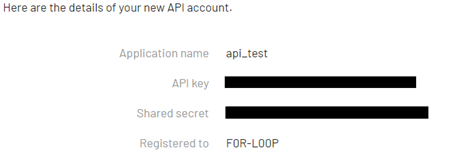

### Making our first API request
In order to create a dataset of popular artists, we’ll be working with the [chart.getTopArtists endpoint](https://www.last.fm/api/show/chart.getTopArtists).

Looking at the documentation, we can see:

* It looks like there is only one real endpoint, and each “endpoint” is actually specified by using the method parameter.
* The API can return results in multiple formats – we’ll specify JSON so we can leverage what we already know about working with APIs in Python

Remember that we need to provide a user-agent header to identify ourselves when we make a request. With the Python requests library, we specify headers using the [headers parameter](https://requests.readthedocs.io/en/master/user/quickstart/#custom-headers) with a dictionary of headers like so:

In [1]:
import requests

# set header
headers = {'user-agent': 'F0R-L00P'}

#apply as parameter
reponse = requests.get('http://my-api-url', headers=headers)

We’ll start by defining our API key and a user-agent.

In [2]:
API_KEY = '54686973206973206d7920415049204b6579'
USER_AGENT = 'F0R-L00P'

Import the requests library, create a dictionary for headers and parameters, and make our first request!

In [3]:
import requests

headers = {'user-agent': USER_AGENT}

payload = {'api_key': API_KEY,
           'method': 'chart.gettopartists',
           'format': 'json'}

response = requests.get('http://ws.audioscrobbler.com/2.0/', headers=headers, params=payload)
response.status_code

200

Our request returned a status code of ‘200’, so we know it was successful.

Before we look at the data returned by our request, let’s think about the fact that we’re going to make many requests. In those requests, a lot of the functionality is going to be the same, such as:

* using the same URL
* using the same API key
* specifying JSON as our format.
* using the same headers.

To save time lets define a function. giving it a payload dictionary, and then we’ll add extra keys to that dictionary and pass it with our other options to make the request.

Let’s look at what that function looks like:

In [4]:
def lastfm_get(payload):
    # define headers and URL
    headers = {'user-agent': USER_AGENT}
    url = 'http://ws.audioscrobbler.com/2.0/'

    # Add API key and format to the payload
    payload['api_key'] = API_KEY
    payload['format'] = 'json'

    response = requests.get(url, headers=headers, params=payload)
    
    return response

In [5]:
response = lastfm_get({'method': 'chart.gettopartists'})

response.status_code

200

Lets check the output JSON file

In [6]:
import json

def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

jprint(response.json())

{
    "artists": {
        "@attr": {
            "page": "1",
            "perPage": "50",
            "total": "3904974",
            "totalPages": "78100"
        },
        "artist": [
            {
                "image": [
                    {
                        "#text": "https://lastfm.freetls.fastly.net/i/u/34s/2a96cbd8b46e442fc41c2b86b821562f.png",
                        "size": "small"
                    },
                    {
                        "#text": "https://lastfm.freetls.fastly.net/i/u/64s/2a96cbd8b46e442fc41c2b86b821562f.png",
                        "size": "medium"
                    },
                    {
                        "#text": "https://lastfm.freetls.fastly.net/i/u/174s/2a96cbd8b46e442fc41c2b86b821562f.png",
                        "size": "large"
                    },
                    {
                        "#text": "https://lastfm.freetls.fastly.net/i/u/300x300/2a96cbd8b46e442fc41c2b86b821562f.png",
                        "si

### Data STructure and Access
The structure of the JSON response is a dictionary with a single artists key, containing:
* an @attr key containing a number of attributes about the response.
* an artist key containing a list of artist objects.

Let’s look at the '@attr' (attributes) key by itself:

In [7]:
jprint(response.json()['artists']['@attr'])

{
    "page": "1",
    "perPage": "50",
    "total": "3904974",
    "totalPages": "78100"
}


### Working with Paginated Data
In order to build a dataset with many artists, we need to make an API request for each page (78k total) and then put them together. We can control the pagination of our results using two optional parameters specified in the documentation:

limit: The number of results to fetch per page (defaults to 50).
page: Which page of the results we want to fetch.
Because the '@attrs' key gives us the total number of pages, we can use a while loop and iterate over pages until the page number is equal to the last page number.

We can also use the limit parameter to fetch more results in each page — we’ll fetch 500 results per page so we only need to make ~6,000 calls instead of ~60,000.

Let’s look at an example of how we would structure that code:

In [8]:
# initialize list for results
results = []

# set initial page and a high total number
page = 1
total_pages = 99999


while page > total_pages:
    # simplified request code for this example
    response = request.get("endpoint_url", params={"page": page})

    # append results to list
    results.append(response.json())

    # increment page
    page += 1

### Rate Limiting with Time
Rate limiting is using code to limit the number of times per second that we hit a particular API. Rate limiting will make your code slower, but it’s better than getting banned from using an API altogether.

The easiest way to perform rate limiting is to use Python [time.sleep() function](https://docs.python.org/3/library/time.html#time.sleep). 

Example:

In [9]:
import time

start = 0
count = 10

while start < count:
    print("counting number {}".format(start))
    time.sleep(0.25)
    start += 1

counting number 0
counting number 1
counting number 2
counting number 3
counting number 4
counting number 5
counting number 6
counting number 7
counting number 8
counting number 9


### Rate Limiting with Database
Another technique that’s useful for rate limiting is using a local database to cache the results of any API call, so that if we make the same call twice, the second time it reads it from the local cache. 

Imagine that as you are writing your code, you discover syntax errors and your loop fails, and you have to start again. By using a local cache, you have two benefits:

1. You don’t make extra API calls that you don’t need to.
2. You don’t need to wait the extra time to rate limit when reading the repeated calls from the cache.

The logic that we could use to combine waiting with a cache looks like the below:

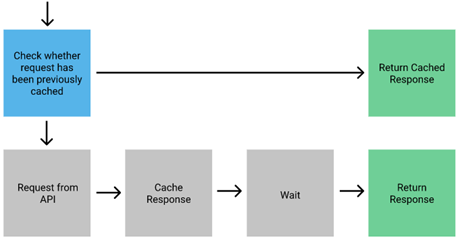

 There’s a great library called [requests-cache](https://requests-cache.readthedocs.io/en/latest/) which will do all of the work for you with only a couple of lines of code.

In [10]:
import requests_cache

requests_cache.install_cache()

In [11]:
import time
from IPython.core.display import clear_output

responses = []

page = 1
total_pages = 99999 # this is just a dummy number so the loop starts

while page <= total_pages:
    payload = {'method': 'chart.gettopartists',
               'limit': 500,
               'page': page}

    # print some output so we can see the status
    print("Requesting page {}/{}".format(page, total_pages))
    # clear the output to make things neater
    clear_output(wait = True)

    # make the API call
    response = lastfm_get(payload)

    # if we get an error, print the response and halt the loop
    if response.status_code != 200:
        print(response.text)
        break

    # extract pagination info
    page = int(response.json()['artists']['@attr']['page'])
    total_pages = int(response.json()['artists']['@attr']['totalPages'])

    # append response
    responses.append(response)

    # if it's not a cached result, sleep
    if not getattr(response, 'from_cache', False):
        time.sleep(0.25)

    # increment the page number
    page += 1

Requesting page 7810/7810


In [12]:
import pandas as pd

# get first element json file
first_page = responses[0].json()
# access list
first_page_artists = first_page['artists']['artist']
# write to dataframe
df = pd.DataFrame(first_page_artists)
# inspect head
df.head()

,name,playcount,listeners,mbid,url,streamable,image
0,The Weeknd,153432460,1822740,c8b03190-306c-4120-bb0b-6f2ebfc06ea9,https://www.last.fm/music/The+Weeknd,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
1,Ariana Grande,216706241,1581348,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,https://www.last.fm/music/Ariana+Grande,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
2,Billie Eilish,84432023,1052858,,https://www.last.fm/music/Billie+Eilish,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
3,Taylor Swift,354686615,2678505,20244d07-534f-4eff-b4d4-930878889970,https://www.last.fm/music/Taylor+Swift,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
4,Kanye West,334465676,4796208,164f0d73-1234-4e2c-8743-d77bf2191051,https://www.last.fm/music/Kanye+West,0,[{'#text': 'https://lastfm.freetls.fastly.net/...


### DataFrame Concatenation
We can use list comprehension, or a F0R-L00P, to perform this operation on each response from responses, giving us a list of dataframes, and then use the [pandas.concat() function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to turn the list of dataframes into a single dataframe.

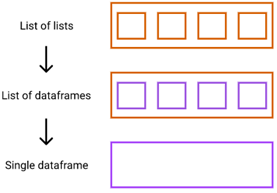

In [13]:
# method 1: using list comprehension:
frames = [pd.DataFrame(r.json()['artists']['artist']) for r in responses]
artists = pd.concat(frames)
artists.head()

,name,playcount,listeners,mbid,url,streamable,image
0,The Weeknd,153432460,1822740,c8b03190-306c-4120-bb0b-6f2ebfc06ea9,https://www.last.fm/music/The+Weeknd,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
1,Ariana Grande,216706241,1581348,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,https://www.last.fm/music/Ariana+Grande,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
2,Billie Eilish,84432023,1052858,,https://www.last.fm/music/Billie+Eilish,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
3,Taylor Swift,354686615,2678505,20244d07-534f-4eff-b4d4-930878889970,https://www.last.fm/music/Taylor+Swift,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
4,Kanye West,334465676,4796208,164f0d73-1234-4e2c-8743-d77bf2191051,https://www.last.fm/music/Kanye+West,0,[{'#text': 'https://lastfm.freetls.fastly.net/...


In [14]:
# method 2: using for-loop
temp = []
for i in responses:
    temp.append(pd.DataFrame(i.json()['artists']['artist']))
df1 = pd.concat(temp)
df1.head()

,name,playcount,listeners,mbid,url,streamable,image
0,The Weeknd,153432460,1822740,c8b03190-306c-4120-bb0b-6f2ebfc06ea9,https://www.last.fm/music/The+Weeknd,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
1,Ariana Grande,216706241,1581348,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,https://www.last.fm/music/Ariana+Grande,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
2,Billie Eilish,84432023,1052858,,https://www.last.fm/music/Billie+Eilish,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
3,Taylor Swift,354686615,2678505,20244d07-534f-4eff-b4d4-930878889970,https://www.last.fm/music/Taylor+Swift,0,[{'#text': 'https://lastfm.freetls.fastly.net/...
4,Kanye West,334465676,4796208,164f0d73-1234-4e2c-8743-d77bf2191051,https://www.last.fm/music/Kanye+West,0,[{'#text': 'https://lastfm.freetls.fastly.net/...


In [15]:
print(df1.shape, artists.shape)

(12000, 7) (12000, 7)


### Exploratory Data Analysis
1. Remove unwanted columns
2. check data

### Modeling
save frame and using in any modeling projects...Happy Analyzing!

In [16]:
# drop images
artists = artists.drop('image', axis=1)
artists.head()

,name,playcount,listeners,mbid,url,streamable
0,The Weeknd,153432460,1822740,c8b03190-306c-4120-bb0b-6f2ebfc06ea9,https://www.last.fm/music/The+Weeknd,0
1,Ariana Grande,216706241,1581348,f4fdbb4c-e4b7-47a0-b83b-d91bbfcfa387,https://www.last.fm/music/Ariana+Grande,0
2,Billie Eilish,84432023,1052858,,https://www.last.fm/music/Billie+Eilish,0
3,Taylor Swift,354686615,2678505,20244d07-534f-4eff-b4d4-930878889970,https://www.last.fm/music/Taylor+Swift,0
4,Kanye West,334465676,4796208,164f0d73-1234-4e2c-8743-d77bf2191051,https://www.last.fm/music/Kanye+West,0


In [17]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        12000 non-null  object
 1   playcount   12000 non-null  object
 2   listeners   12000 non-null  object
 3   mbid        12000 non-null  object
 4   url         12000 non-null  object
 5   streamable  12000 non-null  object
dtypes: object(6)
memory usage: 656.2+ KB


In [18]:
artists.describe()

,name,playcount,listeners,mbid,url,streamable
count,12000,12000,12000,12000,12000,12000
unique,9996,9988,9877,6472,9996,1
top,TV on the Radio,1432262,45526,,https://www.last.fm/music/TV+on+the+Radio,0
freq,3,3,3,4093,3,12000


We were expecting about 3,000,000 artists but we only have 10,500. Of those, only 10,000 are unique (eg there are duplicates).

Let’s let’s look at the length of the list of artists across our list of response objects to see if we can better understand what has gone wrong.

In [19]:
artist_counts = [len(r.json()['artists']['artist']) for r in responses]
pd.Series(artist_counts).value_counts()

0       7790
500       16
1000       4
dtype: int64

It looks like only twenty of our requests had a list of responses – let’s look at the first fifty in order and see if there’s a pattern.

In [20]:
print(artist_counts[:50])

[500, 1000, 500, 1000, 500, 1000, 500, 1000, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


It looks like after the first twenty responses, this API doesn’t return any data — an undocumented limitation.